In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from visdom import Visdom
from callRate import plot_confusion_matrix, plot_ROC

plt.ion()   # interactive modeand

In [2]:
viz = Visdom(env='ssl_sl_exercise3')
viz.line([[0.0, 0.0]], [0.], win='Train', opts=dict(title = 'Train',
                                                    legend = ['Loss', 'Accuracy'],
                                                    xlabel = 'Epoch',
                                                    linecolor= np.array([[51, 153, 255], 
                                                                [225, 102, 102]]),
                                                    dash=np.array(['dash','dash'])))
viz.line([0.], [0.], win='Test_acc', opts=dict(title='Test_acc',legend=['Accuracy'], xlabel = 'Epoch',
                                                    linecolor= np.array([[150, 100, 255]]),
                                                    dash=np.array(['dash'])))

viz.line([0.], [0.], win='B', opts=dict(title='Blistering', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), dash =np.array(['dash'])))
viz.line([0.], [0.], win='C', opts=dict(title='Crack', legend=[ 'Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), dash =np.array(['dash'])))
viz.line([0.], [0.], win='D', opts=dict(title='Delemination', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), dash =np.array(['dash'])))
viz.line([0.], [0.], win='G', opts=dict(title='Biological growth', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), dash =np.array(['dash'])))
viz.line([0.], [0.], win='N', opts=dict(title='No defects', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), dash =np.array(['dash'])))
viz.line([0.], [0.], win='P', opts=dict(title='Peeling', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), dash =np.array(['dash'])))
viz.line([0.], [0.], win='S', opts=dict(title='Spalling', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), dash =np.array(['dash'])))

Setting up a new session...


'S'

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.588, 0.618, 0.630], [0.092, 0.086, 0.086]),        
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        
        transforms.Normalize([0.588, 0.618, 0.630], [0.092, 0.086, 0.086])
    ]),
}

data_dir = 'data-local/images/facade/exercise_data3_label'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) 
                  for x in ['train', 'test']}

weights = [18.33, 6.85, 11.70, 66.25, 1, 4.01, 19.48] #weight on each class
class_sizes = [142, 381, 223, 39, 2610, 651, 134]
sampleWeights = [] #oversampling weight on each sample
for i in range(0, len(weights)):
    sampleWeights += [weights[i]]*class_sizes[i]

sampler = WeightedRandomSampler(sampleWeights, num_samples=len(sampleWeights), replacement = True)

oversampling = False

if oversampling:
    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=20,
                                                        sampler = sampler, num_workers=2),
                   'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=20,
                                                       shuffle=True, num_workers=2)}
else:
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                                  shuffle=True, num_workers=2)
                   for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print (class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

{'train': 350, 'test': 996}
['b', 'c', 'd', 'g', 'n', 'p', 's']


tensor([5, 4, 2, 4, 3, 5, 2, 1, 5, 3, 3, 0, 6, 2, 5, 4, 6, 6, 2, 2, 5, 3, 2, 1,
        4, 5, 4, 5, 5, 1, 0, 0])


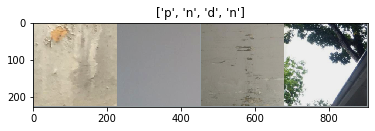

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.588, 0.618, 0.630])
    std = np.array([0.092, 0.086, 0.086])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs2 = inputs [:4]
classes2 = classes[:4]
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs2)
imshow(out, title=[class_names[x] for x in classes2])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    global_step = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        global_step += 1
        cm_labels = []
        cm_preds = []
        total_outputs = []

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
#                 print(optimizer)
                
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            class_correct = list(0. for i in range(num_classes))
            class_total = list(0. for i in range(num_classes))
            class_acc = {} 
            for inputs, labels in dataloaders[phase]:
#                 print(len(dataloaders[phase]))
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()


                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    print(loss)
                           

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                if phase == 'test':
                    cm_labels += labels.tolist()
                    cm_preds += preds.tolist()
                    total_outputs += outputs.cpu().numpy().tolist()
                    res = preds.eq(labels)
                    for label_idx in range(len(labels)):
                        label_single = labels[label_idx]
                        class_correct[label_single] += res[label_idx].item()
                        class_total[label_single] += 1
                        
               
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels).float().sum().item()
                                
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                viz.line([[epoch_loss, epoch_acc]],[global_step],win = 'Train', update='append')
                
            if phase == 'test':
                viz.line([epoch_acc*100],
                          [global_step-1], win = 'Test_acc', update = 'append')
                for i in range(num_classes):
                    if class_total[i] == 0:
                        accuracy = 0
                    else:
                        accuracy = class_correct[i]/class_total[i]                        
                    class_acc[class_names[i]] = accuracy
                    viz.line([accuracy], [global_step], win = class_names[i], update = 'append')
                print(class_acc)
                
                
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
               
            

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_labels = cm_labels
                best_preds = cm_preds
                best_outputs = total_outputs
                best_model_wts = copy.deepcopy(model.state_dict())
            
            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))
    plot_confusion_matrix(best_labels, best_preds, classes = class_names, normalize = True)
    fpr, tpr, precision, recall, f1, specificity = plot_ROC(best_labels, best_preds, best_outputs, class_names = class_names)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, fpr, tpr, precision, recall, f1, best_labels, best_preds, best_outputs, specificity 

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# model_ft = nn.DataParallel(model_ft, device_ids=[1]) #multi-GPU
model_ft = model_ft.to(device)


CE = nn.CrossEntropyLoss() #cross entropy loss

criterion = CE

# Observe that all parameters are being optimized

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.9)

Epoch 0/39
----------
tensor(1.9955, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0157, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8433, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8878, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8750, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9345, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9219, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8333, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9488, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8812, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8412, device='cuda:0', grad_fn=<NllLossBackward>)
train Loss: 1.9075 Acc: 0.2057
tensor(1.7557, device='cuda:0')
tensor(1.8558, device='cuda:0')
tensor(1.8515, device='cuda:0')
tensor(1.7512, device='cuda:0')
tensor(1.8844, device='cuda:0')
tensor(1.8702, device='cuda:0')
tensor(1.7777, device='cuda:0')
tensor(1.8711, device='cuda:0')
tensor(1.7543, device='cuda:0')
tensor(1.8

tensor(0.9304, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7994, device='cuda:0', grad_fn=<NllLossBackward>)
train Loss: 0.9196 Acc: 0.7686
tensor(0.9805, device='cuda:0')
tensor(1.2082, device='cuda:0')
tensor(1.1045, device='cuda:0')
tensor(1.0922, device='cuda:0')
tensor(1.0199, device='cuda:0')
tensor(1.0290, device='cuda:0')
tensor(1.0857, device='cuda:0')
tensor(1.0132, device='cuda:0')
tensor(1.0081, device='cuda:0')
tensor(1.0620, device='cuda:0')
tensor(1.1651, device='cuda:0')
tensor(1.0112, device='cuda:0')
tensor(1.0800, device='cuda:0')
tensor(0.9354, device='cuda:0')
tensor(1.1061, device='cuda:0')
tensor(0.9167, device='cuda:0')
tensor(0.7881, device='cuda:0')
tensor(1.1354, device='cuda:0')
tensor(1.0221, device='cuda:0')
tensor(1.1414, device='cuda:0')
tensor(1.1139, device='cuda:0')
tensor(0.8996, device='cuda:0')
tensor(0.9632, device='cuda:0')
tensor(1.0290, device='cuda:0')
tensor(0.8725, device='cuda:0')
tensor(1.1281, device='cuda:0')
tensor(1.1414, devi

tensor(0.6177, device='cuda:0')
tensor(0.5702, device='cuda:0')
tensor(0.7636, device='cuda:0')
tensor(0.8634, device='cuda:0')
tensor(0.9122, device='cuda:0')
tensor(0.6393, device='cuda:0')
tensor(0.6473, device='cuda:0')
tensor(0.6604, device='cuda:0')
tensor(0.5616, device='cuda:0')
tensor(1.0952, device='cuda:0')
tensor(0.8448, device='cuda:0')
tensor(0.6515, device='cuda:0')
tensor(0.5362, device='cuda:0')
tensor(0.6149, device='cuda:0')
tensor(0.7570, device='cuda:0')
tensor(0.6879, device='cuda:0')
tensor(0.7156, device='cuda:0')
tensor(0.7750, device='cuda:0')
tensor(0.7755, device='cuda:0')
tensor(0.4164, device='cuda:0')
{'b': 0.6896551724137931, 'c': 0.8375, 'd': 0.696969696969697, 'g': 0.8383838383838383, 'n': 0.8670212765957447, 'p': 0.6226415094339622, 's': 0.7339449541284404}
test Loss: 0.7133 Acc: 0.7570
Epoch 9/39
----------
tensor(0.3110, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3426, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3014, device='cuda

tensor(0.5680, device='cuda:0')
{'b': 0.7844827586206896, 'c': 0.875, 'd': 0.6, 'g': 0.8686868686868687, 'n': 0.8617021276595744, 'p': 0.6477987421383647, 's': 0.7431192660550459}
test Loss: 0.6384 Acc: 0.7651
Epoch 13/39
----------
tensor(0.1415, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2769, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2060, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1508, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2525, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1554, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1989, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1122, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1626, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1879, device='cuda:0', grad_fn=<NllLossBackward>)
train Loss: 0.1864 Acc: 0.9543
tensor(0.3567, device='cuda:0')
tensor(0.6781, device='cuda:0')
tensor(0.6979, device='

tensor(0.1099, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0443, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0937, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1204, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1043, device='cuda:0', grad_fn=<NllLossBackward>)
train Loss: 0.0795 Acc: 0.9914
tensor(0.7073, device='cuda:0')
tensor(0.4447, device='cuda:0')
tensor(0.4998, device='cuda:0')
tensor(0.6293, device='cuda:0')
tensor(0.5857, device='cuda:0')
tensor(0.3971, device='cuda:0')
tensor(0.5595, device='cuda:0')
tensor(0.5539, device='cuda:0')
tensor(0.7791, device='cuda:0')
tensor(0.5147, device='cuda:0')
tensor(0.6791, device='cuda:0')
tensor(0.7107, device='cuda:0')
tensor(0.5920, device='cuda:0')
tensor(1.0315, device='cuda:0')
tensor(0.6784, device='cuda:0')
tensor(0.4979, device='cuda:0')
tensor(0.7776, device='cuda:0')
tensor(0.4181, device='cuda:0')
tensor(0.7181, device='cuda:0')
tensor(0.6364, device='cuda:0')
tensor(0.2033, device='cuda:0')
te

tensor(0.5614, device='cuda:0')
tensor(0.7215, device='cuda:0')
tensor(0.9165, device='cuda:0')
tensor(0.5863, device='cuda:0')
tensor(0.4162, device='cuda:0')
tensor(0.4744, device='cuda:0')
tensor(0.3466, device='cuda:0')
tensor(0.5658, device='cuda:0')
tensor(0.5395, device='cuda:0')
tensor(0.7632, device='cuda:0')
tensor(0.6962, device='cuda:0')
tensor(0.5428, device='cuda:0')
tensor(0.6165, device='cuda:0')
tensor(0.5742, device='cuda:0')
tensor(0.7402, device='cuda:0')
tensor(0.5772, device='cuda:0')
tensor(0.4629, device='cuda:0')
tensor(0.5474, device='cuda:0')
tensor(0.5698, device='cuda:0')
tensor(0.5469, device='cuda:0')
tensor(0.6937, device='cuda:0')
tensor(0.6187, device='cuda:0')
tensor(0.6922, device='cuda:0')
{'b': 0.7327586206896551, 'c': 0.9, 'd': 0.6363636363636364, 'g': 0.8585858585858586, 'n': 0.9414893617021277, 'p': 0.6918238993710691, 's': 0.7522935779816514}
test Loss: 0.5916 Acc: 0.7912
Epoch 22/39
----------
tensor(0.0538, device='cuda:0', grad_fn=<NllLossBa

tensor(0.2865, device='cuda:0')
tensor(0.5269, device='cuda:0')
tensor(0.6645, device='cuda:0')
tensor(0.3509, device='cuda:0')
tensor(0.0871, device='cuda:0')
{'b': 0.7068965517241379, 'c': 0.8625, 'd': 0.6484848484848484, 'g': 0.8787878787878788, 'n': 0.9414893617021277, 'p': 0.7169811320754716, 's': 0.7889908256880734}
test Loss: 0.6012 Acc: 0.7942
Epoch 26/39
----------
tensor(0.0397, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0269, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0161, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0433, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0394, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0273, device='cuda:0', g

tensor(0.0330, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0537, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0223, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward>)
train Loss: 0.0269 Acc: 1.0000
tensor(0.5042, device='cuda:0')
tensor(0.5377, device='cuda:0')
tensor(0.4233, device='cuda:0')
tensor(0.6585, device='cuda:0')
tensor(1.0390, device='cuda:0')
tensor(0.5460, device='cuda:0')
tensor(0.8123, device='cuda:0')
tensor(0.7849, device='cuda:0')
tensor(0.4361, device='cuda:0')
tensor(0.6591, device='cuda:0')
tensor(0.4632, device='cuda:0')
tensor(0.4466, device='cuda:0')
tensor(0.4774, device='cuda:0')
tensor(0.4886, device='cuda:0')
tensor(1.1584, device='cuda:0')
tensor(0.4088, de

tensor(0.6540, device='cuda:0')
tensor(0.5919, device='cuda:0')
tensor(0.5172, device='cuda:0')
tensor(0.4269, device='cuda:0')
tensor(0.7035, device='cuda:0')
tensor(0.1409, device='cuda:0')
tensor(0.7096, device='cuda:0')
tensor(0.7687, device='cuda:0')
tensor(1.4338, device='cuda:0')
tensor(0.4510, device='cuda:0')
tensor(0.8251, device='cuda:0')
tensor(0.6151, device='cuda:0')
tensor(0.7809, device='cuda:0')
tensor(0.7272, device='cuda:0')
tensor(0.4762, device='cuda:0')
tensor(0.4046, device='cuda:0')
tensor(0.5156, device='cuda:0')
tensor(0.3802, device='cuda:0')
tensor(0.5981, device='cuda:0')
tensor(0.4459, device='cuda:0')
tensor(0.6084, device='cuda:0')
tensor(0.6384, device='cuda:0')
tensor(0.8128, device='cuda:0')
tensor(0.3764, device='cuda:0')
tensor(0.9287, device='cuda:0')
tensor(0.3694, device='cuda:0')
tensor(0.6141, device='cuda:0')
tensor(0.4542, device='cuda:0')
tensor(0.1542, device='cuda:0')
{'b': 0.7155172413793104, 'c': 0.875, 'd': 0.6727272727272727, 'g': 0.84

tensor(0.6558, device='cuda:0')
tensor(0.2889, device='cuda:0')
tensor(0.6062, device='cuda:0')
tensor(0.3973, device='cuda:0')
tensor(0.7043, device='cuda:0')
tensor(0.4001, device='cuda:0')
tensor(0.5323, device='cuda:0')
tensor(0.5684, device='cuda:0')
tensor(0.4260, device='cuda:0')
tensor(0.6623, device='cuda:0')
tensor(0.5513, device='cuda:0')
{'b': 0.7672413793103449, 'c': 0.8875, 'd': 0.6545454545454545, 'g': 0.8686868686868687, 'n': 0.9361702127659575, 'p': 0.6855345911949685, 's': 0.7706422018348624}
test Loss: 0.5936 Acc: 0.7972
Epoch 39/39
----------
tensor(0.0408, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0269, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0219, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0130, dev

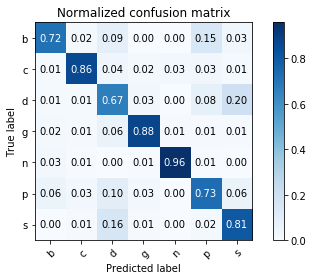

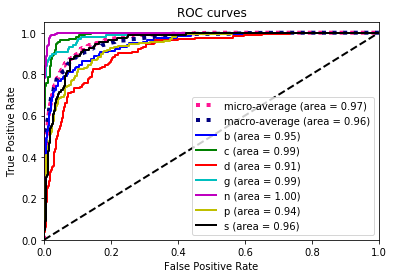

In [8]:
model, fpr, tpr, precision, recall, f1, best_labels, best_preds, best_outputs, specificity = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

In [9]:
print('fpr: {0}'.format(fpr))
print('tpr: {0}'.format(tpr))
print('precision: {0}'.format(precision))
print('recall: {0}'.format(recall))
print('f1: {0}'.format(f1))
print('specificity: {0}'.format(specificity))

fpr: {0: array([0.        , 0.        , 0.        , 0.00113636, 0.00113636,
       0.00227273, 0.00227273, 0.00340909, 0.00340909, 0.00454545,
       0.00454545, 0.00568182, 0.00568182, 0.00681818, 0.00681818,
       0.00795455, 0.00795455, 0.01022727, 0.01022727, 0.01136364,
       0.01136364, 0.0125    , 0.0125    , 0.01477273, 0.01477273,
       0.01590909, 0.01590909, 0.01704545, 0.01704545, 0.01931818,
       0.01931818, 0.02045455, 0.02045455, 0.02386364, 0.02386364,
       0.02613636, 0.02613636, 0.02727273, 0.02727273, 0.02840909,
       0.02840909, 0.03522727, 0.03522727, 0.04090909, 0.04090909,
       0.04204545, 0.04204545, 0.05113636, 0.05113636, 0.05568182,
       0.05568182, 0.06022727, 0.06022727, 0.06931818, 0.06931818,
       0.07272727, 0.07272727, 0.08636364, 0.08636364, 0.09090909,
       0.09090909, 0.09431818, 0.09431818, 0.10340909, 0.10340909,
       0.11363636, 0.11363636, 0.13977273, 0.13977273, 0.14772727,
       0.14772727, 0.16477273, 0.16477273, 0.16704545

In [10]:
# print(best_labels)

In [11]:
# print(best_preds)

In [12]:
# print(best_outputs)